In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from matplotlib import font_manager, rc
import matplotlib

#한글 폰트 등록
font_location = "c:/Windows/fonts/malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [3]:
# import pandas as pd

# # 판다스 데이터프레임(DataFrame)을 출력할 때, 최대 출력할 수 있는 컬럼을 100개로 늘려줍니다.
# # 이렇게 해야 데이터를 분석할 때 출력해서 확인하기 편합니다.
pd.options.display.max_columns = 300
pd.options.display.max_rows = 300

In [4]:
train = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/train.csv')
test = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/test.csv')
submission = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/submission.csv')

# to_datetime

train['Time'] = train['Time'].apply(pd.to_datetime)
train.set_index('Time',inplace=True)

test['Time'] = test['Time'].apply(pd.to_datetime)
test.set_index('Time',inplace=True)

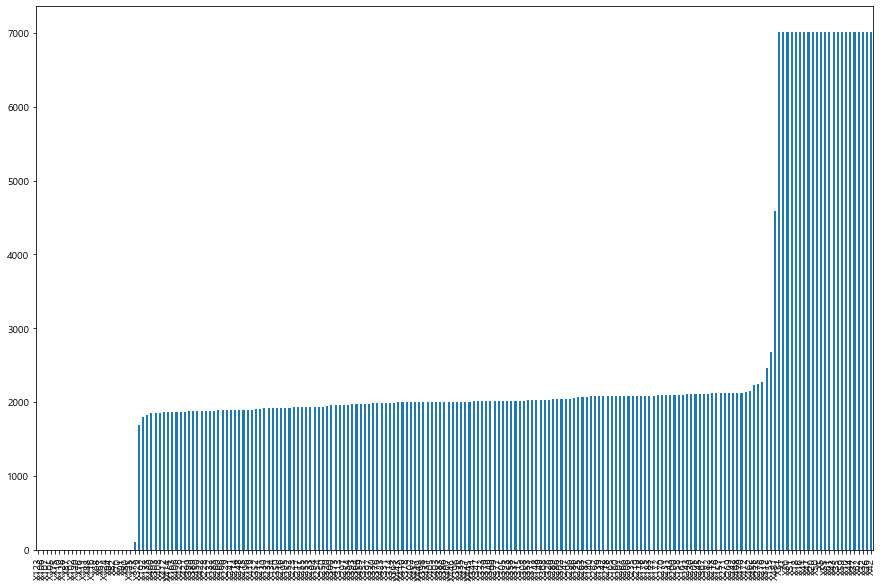

In [5]:
# 결측치 갯수 시각화
test.isnull().sum().sort_values(ascending=True).plot(kind='bar',figsize=(15,10))

In [6]:
## 결측치가 없는 세대
test.loc[:,test.isnull().sum()==0].columns

Index(['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107'],
      dtype='object')

In [7]:
# sample 데이터
test_sample = test[['X125', 'X76', 'X106', 'X94', 'X123', 'X111', 'X67', 'X91', 'X87',
       'X126', 'X120', 'X110', 'X105', 'X88', 'X116', 'X68', 'X124', 'X82',
       'X80', 'X102', 'X70', 'X75', 'X107']]

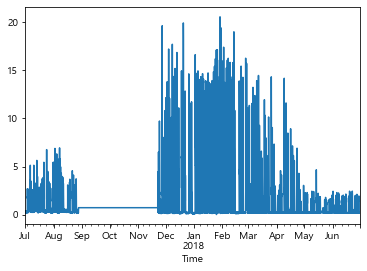

In [8]:
test_sample['X125'].plot()

In [16]:
ASDFASDF

NameError: name 'ASDFASDF' is not defined

In [642]:
# 기상 데이터 load

weather_1 = pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/기상_1.csv',encoding='euc-kr',index_col='일시',parse_dates=True)
del weather_1['지점']

weather_2= pd.read_csv('C:/Users/KIHyuk/Desktop/전력수요예측/기상_2.csv',encoding='euc-kr',index_col='일시',parse_dates=True)
del weather_2['지점']

weather = pd.concat([weather_1,weather_2])

test_sample['기온'] = weather['기온(°C)']

# subset = test_sample[['X125','기온']]
# rnn_list = [list(x) for x in subset.values]

# test_sample['X125_RNN'] = rnn_list

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [643]:
train_s = test_sample.loc['2017-12':'2018-05',['X125']]
test_s = test_sample.loc['2018-06':, ['X125']]


train_t = test_sample.loc['2017-12':'2018-05',['기온']]
test_t = test_sample.loc['2018-06':, ['기온']]

# Feature는 Unadjusted 한 개

# ax = train_s.plot()
# test_s.plot(ax=ax)
# plt.legend(['train_s', 'test_s'])

In [644]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train_s)
test_sc = sc.transform(test_s)

train_tc = sc.fit_transform(train_t)
test_tc = sc.transform(test_t)

train_sc

array([[0.01187753],
       [0.00915154],
       [0.00949228],
       ...,
       [0.01041717],
       [0.01387334],
       [0.00963832]])

In [645]:
# rnn_list_train=[]
# for i in range(len(train_sc)):
#     tmp_list = [train_sc[i][0],train_tc[i][0]]
#     rnn_list_train.append(tmp_list)
    
# rnn_list_test=[]
# for i in range(len(test_sc)):
#     tmp_list = [test_sc[i][0],test_tc[i][0]]
#     rnn_list_test.append(tmp_list)
    
# train_sc = np.array(rnn_list_train)
# test_sc = np.array(rnn_list_test) 

In [646]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'] ,index=train_s.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test_s.index)
# train_sc_df.head()
train_tc_df = pd.DataFrame(train_tc, columns=['Scaled'] ,index=train_s.index)
test_tc_df = pd.DataFrame(test_tc, columns=['Scaled'], index=test_s.index)

In [647]:
for s in range(1, 13):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)
    
    train_tc_df['shift_{}'.format(s)] = train_tc_df['Scaled'].shift(s)
    test_tc_df['shift_{}'.format(s)] = test_tc_df['Scaled'].shift(s)

# train_sc_df.head(13)

In [648]:
X_train = train_sc_df.dropna().drop(['Scaled'], axis=1)
y_train = train_sc_df.dropna()[['Scaled']]
X_train_t = train_tc_df.dropna().drop(['Scaled'], axis=1)
y_train_t = train_tc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop(['Scaled'], axis=1)
y_test = test_sc_df.dropna()[['Scaled']]
X_test_t = test_tc_df.dropna().drop(['Scaled'], axis=1)
y_test_t = test_tc_df.dropna()[['Scaled']]

In [653]:
X_train.shape

(4356, 1, 52272, 1, 2)

In [651]:
X_train_tmp = []
tmp_X_train = []
tmp2_X_train = []
RES = []
for i in range(0,4356):
    for j in range(0,12):
        tmp_X_train = [X_train.values[i][j], X_train_t.values[i][j]]
        tmp2_X_train.append([tmp_X_train])
    RES.append([tmp2_X_train])
            
X_train = np.asarray(RES)

In [652]:
X_train

array([[[[[0.14506158, 0.37416481]],

         [[0.24918464, 0.34075724]],

         [[0.59090688, 0.28953229]],

         ...,

         [[0.06629996, 0.87305122]],

         [[0.06542375, 0.85077951]],

         [[0.07029158, 0.83964365]]]],



       [[[[0.14506158, 0.37416481]],

         [[0.24918464, 0.34075724]],

         [[0.59090688, 0.28953229]],

         ...,

         [[0.06629996, 0.87305122]],

         [[0.06542375, 0.85077951]],

         [[0.07029158, 0.83964365]]]],



       [[[[0.14506158, 0.37416481]],

         [[0.24918464, 0.34075724]],

         [[0.59090688, 0.28953229]],

         ...,

         [[0.06629996, 0.87305122]],

         [[0.06542375, 0.85077951]],

         [[0.07029158, 0.83964365]]]],



       ...,



       [[[[0.14506158, 0.37416481]],

         [[0.24918464, 0.34075724]],

         [[0.59090688, 0.28953229]],

         ...,

         [[0.06629996, 0.87305122]],

         [[0.06542375, 0.85077951]],

         [[0.07029158, 0.83964365]]]],


In [453]:
X_train_tmp = []
tmp_X_train = []
tmp2_X_train = []
for i in range(0,12):
    X_train_tmp.append([tmp2_X_train])
    for j in range(0,12):
        tmp_X_train = [X_train.values[i][j],X_train_t.values[i][j]]
        tmp2_X_train.append(tmp_X_train)

y_train_tmp = []    
tmp_y_train = []
for i in range(0,4356):
    tmp_y_train = [y_train.values[i][0],y_train_t.values[i][0]]
    y_train_tmp.append(tmp_y_train)
    
X_train = np.asarray(X_train_tmp)
Y_train = np.asarray(y_train_tmp)

#####################################################

X_test_tmp = []
tmp_X_test = []
for i in range(0,708):
    for j in range(0,12):
        tmp_X_test = [X_test.values[i][j],X_test_t.values[i][j]]
    X_test_tmp.append(tmp_X_test)

y_test_tmp = []    
tmp_y_test = []
for i in range(0,708):
    tmp_y_test = [y_test.values[i][0],y_test_t.values[i][0]]
    y_test_tmp.append(tmp_y_test)
    
X_test = np.asarray(X_test_tmp)
Y_test = np.asarray(y_test_tmp)

In [471]:
# print(X_train.shape)
# print(X_train)
print(Y_train.shape)
print(Y_train)

(4356, 2)
[[0.09049311 0.39643653]
 [0.09730809 0.42093541]
 [0.12349705 0.42761693]
 ...
 [0.01041717 0.80846325]
 [0.01387334 0.80623608]
 [0.00963832 0.81737194]]


In [513]:
s=np.arange(228)

s.reshape(228,12,1)

ValueError: cannot reshape array of size 228 into shape (228,12,1)

In [384]:
X_train_res = X_train.reshape(X_train.shape[0], 12, 2)
X_test_res = X_test.reshape(X_test.shape[0], 12, 2)

print("최종 DATA")
print(X_train_res.shape)
print('##################################')
print(X_train_res)
print('##################################')
print(y_train)

ValueError: cannot reshape array of size 8712 into shape (4356,12,2)

In [220]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
import keras.backend as K 
from keras.callbacks import EarlyStopping 
K.clear_session() 
model = Sequential() # Sequeatial Model 
model.add(LSTM(20, return_sequences=True, input_shape=(12, 1))) # (timestep, feature) 
model.add(Dense(1)) # output = 1 
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 12, 20)            1760      
_________________________________________________________________
dense_1 (Dense)              (None, 12, 1)             21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [221]:
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(X_train_res, y_train, epochs=100,
          batch_size=30, verbose=1, callbacks=[early_stop])

ValueError: Error when checking input: expected lstm_1_input to have shape (12, 1) but got array with shape (12, 2)

In [ ]:
y_pred = model.predict(X_test_res)
# print(y_pred)

In [ ]:
plt.figure()
plt.plot(y_pred)
plt.plot(y_test)